# Imports

In [1]:
!pip install tensorflow keras matplotlib scipy opencv-python

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split

import seaborn as sns

import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers import Dense, Conv2D, MaxPooling2D , Flatten, Dropout
from keras.models import Sequential

2024-11-27 10:54:17.753917: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-27 10:54:17.841914: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
train_df = pd.read_pickle("train_df.pkl")
test_df = pd.read_pickle("test_df.pkl")

# Utils

In [4]:
def data_flow_fct(df, datagen, batch_size=32):

    data_flow = datagen.flow_from_dataframe(
        df, 
        directory='',
        x_col='filename',
        y_col='label_name',
        weight_col=None,
        target_size=(224, 224),
        classes=None,
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=42
    )
    
    return data_flow

# Generating training and test data

### Filtering three classes : 'Chihuahua', 'Japanese_spaniel' and 'Maltese_dog'

In [5]:
mask_train = (train_df.label_name == 'Chihuahua') | (train_df.label_name == 'Japanese_spaniel') | (train_df.label_name == 'Maltese_dog')
train_val_df_reduced = train_df.loc[mask_train, :]

mask_test = (test_df.label_name == 'Chihuahua') | (test_df.label_name == 'Japanese_spaniel') | (test_df.label_name == 'Maltese_dog')
test_df_reduced = test_df.loc[mask_test, :]

In [6]:
train_val_df_reduced.label_name.value_counts()

label_name
Chihuahua           100
Japanese_spaniel    100
Maltese_dog         100
Name: count, dtype: int64

### Splitting train and val sets

In [7]:
train_df_reduced, val_df_reduced = train_test_split(
    train_val_df_reduced, 
    test_size=0.25, 
    stratify=train_val_df_reduced['label_name'],
    random_state=42
)

In [8]:
train_df_reduced.label_name.value_counts()

label_name
Maltese_dog         75
Japanese_spaniel    75
Chihuahua           75
Name: count, dtype: int64

In [9]:
val_df_reduced.label_name.value_counts()

label_name
Japanese_spaniel    25
Chihuahua           25
Maltese_dog         25
Name: count, dtype: int64

### Creating image generators

In [10]:
# train data generator with data augmentation
datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_flow = data_flow_fct(train_df_reduced, datagen_train)
val_flow = data_flow_fct(val_df_reduced, datagen_train)


# train data generator without data augmentation
datagen_train_not_augmented = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
)

train_flow_not_augmented = data_flow_fct(train_df_reduced, datagen_train_not_augmented)
val_flow_not_augmented = data_flow_fct(val_df_reduced, datagen_train_not_augmented)


# test data generator
datagen_test = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255
)

test_flow = data_flow_fct(test_df_reduced, datagen_test)

Found 225 validated image filenames belonging to 3 classes.
Found 75 validated image filenames belonging to 3 classes.
Found 225 validated image filenames belonging to 3 classes.
Found 75 validated image filenames belonging to 3 classes.
Found 289 validated image filenames belonging to 3 classes.


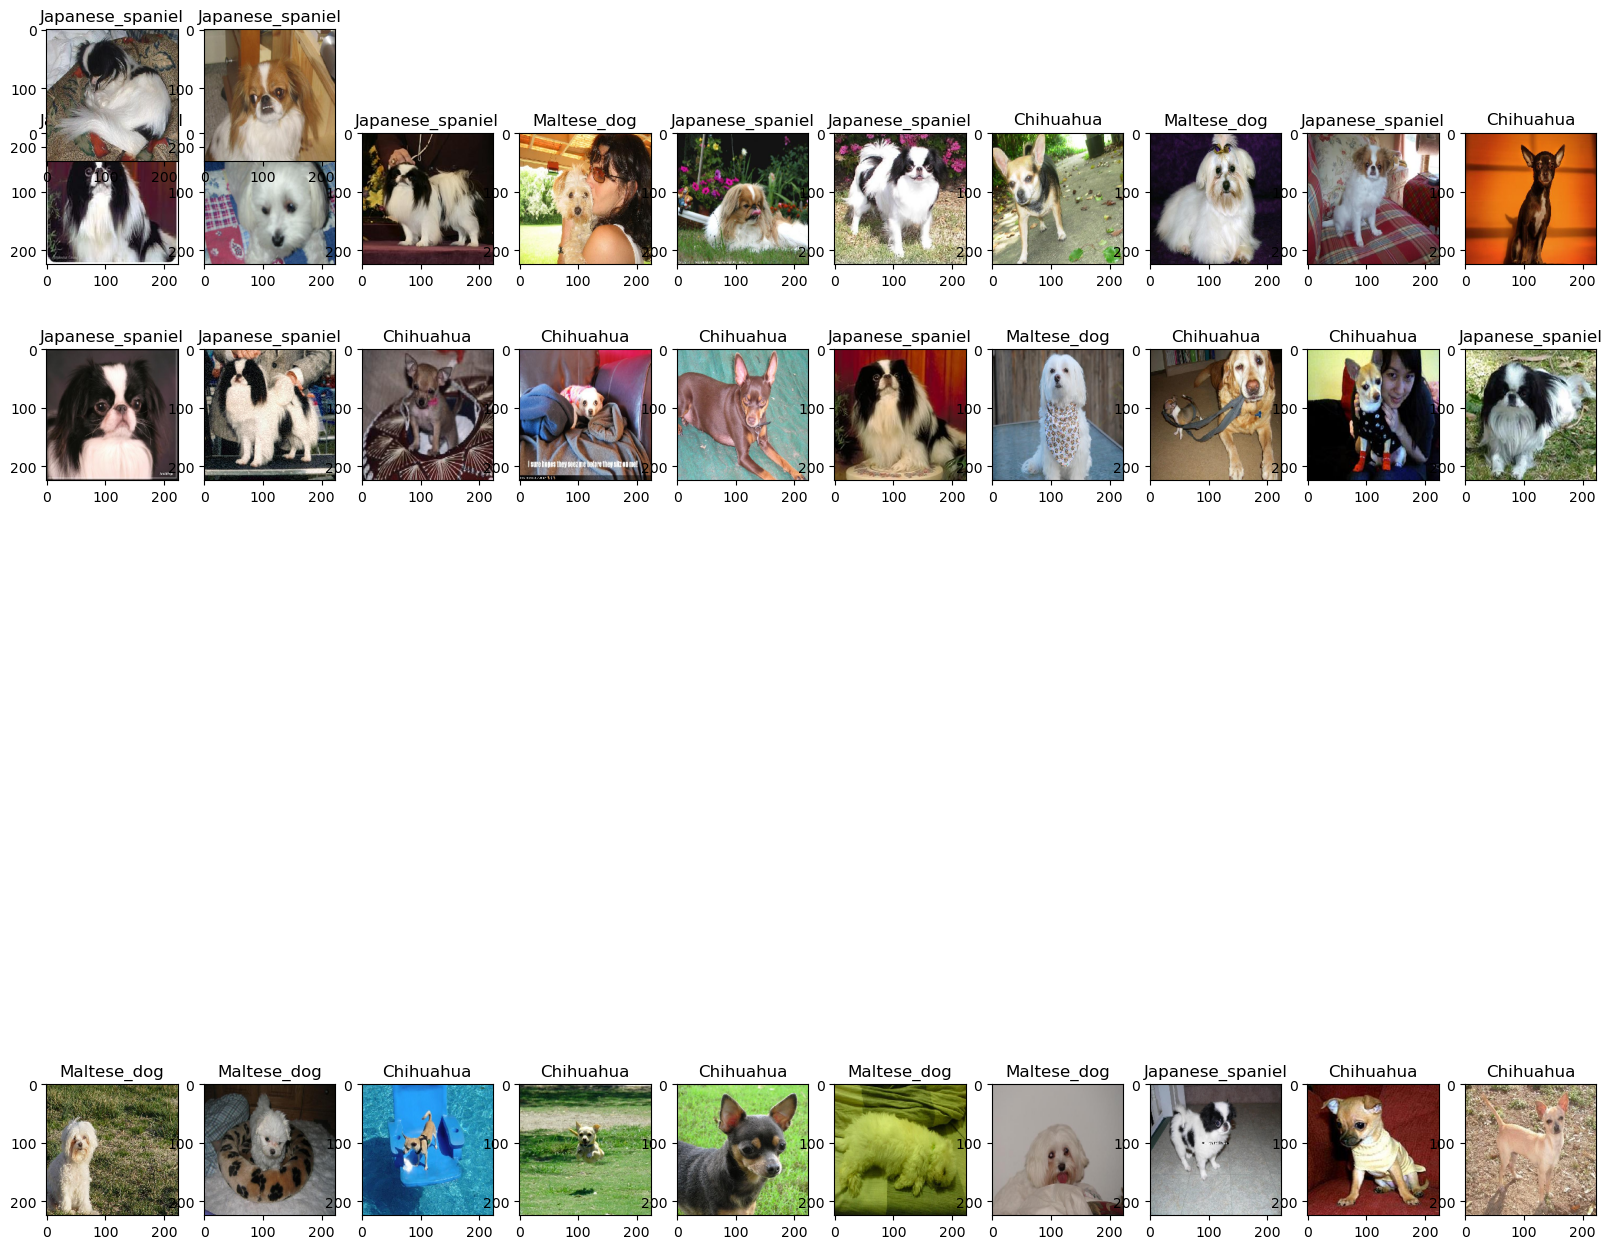

In [11]:
images, labels = next(train_flow_not_augmented)
plt.figure(figsize=(20, 35))
for i in range(len(images)):
    plt.subplot(i//10+1,10,i%10+1)
    plt.imshow(images[i])
    plt.title(list(train_flow_not_augmented.class_indices.keys())[np.argmax(labels[i])])
plt.show()

# Functions to train and evaluate model

In [12]:
results_df = pd.DataFrame(columns=["model_name", "accuracy on test set"])

In [13]:
def create_model_callback(model_name):
    """"
    
    Create model checkpoint and early stopping used for the training

    params:
    model_name: str: name of the future model

    """
    
    model_save_path = f"models/{model_name}.keras"
    
    checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights=False)
    
    callbacks_list = [checkpoint, es]

    return callbacks_list


def create_model_callback_patience10(model_name):
    """"
    
    Create model checkpoint and early stopping used for the training

    params:
    model_name: str: name of the future model

    """
    
    model_save_path = f"models/{model_name}.keras"
    
    checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=False)
    
    callbacks_list = [checkpoint, es]

    return callbacks_list


In [14]:
def train_model(model, callbacks_list, train_flow=train_flow, val_flow=val_flow, nb_epochs=10, batch_size=32):
    with tf.device('/gpu:0'): 
        history = model.fit(train_flow, validation_data=val_flow, batch_size=batch_size, epochs=nb_epochs, callbacks=callbacks_list, verbose=1)
    return history


In [15]:
def plot_loss_and_accuracy(history):
    # Loss plot
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy plot
    if 'accuracy' in history.history:
        plt.figure(figsize=(8, 5))
        plt.plot(history.history['accuracy'], label='Training Accuracy', color='green')
        if 'val_accuracy' in history.history:
            plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
        plt.title('Model Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()


In [16]:
def display_matrix_scores(model, model_name, test_flow=test_flow, results_df=results_df):
    
    model.load_weights(f"models/{model_name}.keras")
    predictions = model.predict(test_flow)
    
    y_pred = [np.argmax(pred)  for pred in predictions]
    y_val = [label for label in test_flow.classes]
    
    conf_mat = metrics.confusion_matrix(y_val, y_pred)
    print(metrics.classification_report(y_val, y_pred))
    
    df_cm = pd.DataFrame(conf_mat, index = [label for label in test_flow.class_indices])
    plt.figure(figsize = (6,4))
    sns.heatmap(df_cm, annot=True, cmap="Blues")

    results_df.loc[len(results_df)] = {"model_name":model_name, "accuracy on test set": metrics.f1_score(y_val, y_pred, average="macro")}
    

In [17]:
def create_model_custom_0(train_flow=train_flow):
    """
    
    Create simple base model
    
    """

    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units=64, activation='relu'))

    model.add(Dense(units=len(train_flow.class_indices), activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    
    return model


In [18]:
def create_model_custom_2(train_flow=train_flow):
    """
    
    Create a model with a different learning rate
    
    """

    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units=64, activation='relu'))

    model.add(Dense(units=len(train_flow.class_indices), activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    
    return model

In [19]:
def create_model_custom_4(train_flow=train_flow):

    """
    
    Create simple base model with more layers than the base model
    
    """

    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(units=128, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=len(train_flow.class_indices), activation='softmax'))

    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    
    return model

# Model implementations

### First model

In [20]:
model_0 = create_model_custom_0()

/home/omar-oc/anaconda3/envs/env_OC_P6/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    25,233,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,234,563 (96.26 MB)

 Trainable params: 25,234,563 (96.26 MB)

 Non-trainable params: 0 (0.00 B)

None


In [21]:
callbacks_list_0 = create_model_callback("model_0")

In [22]:
history_0 = train_model(model_0, callbacks_list_0)

/home/omar-oc/anaconda3/envs/env_OC_P6/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.3574 - loss: 18.1100
Epoch 1: val_loss improved from inf to 8.63664, saving model to models/model_0.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 689ms/step - accuracy: 0.3532 - loss: 18.0832 - val_accuracy: 0.3600 - val_loss: 8.6366
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.4595 - loss: 4.5587
Epoch 2: val_loss improved from 8.63664 to 3.01105, saving model to models/model_0.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 657ms/step - accuracy: 0.4533 - loss: 4.4683 - val_accuracy: 0.4533 - val_loss: 3.0111
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.5044 - loss: 2.3140
Epoch 3: val_loss improved from 3.01105 to 1.67880, saving model to models/model_0.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 632ms/step - accuracy: 0.4962 - loss: 2.2928 - val_accuracy: 0.3467 - val_loss: 1.6788
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.4170 - loss: 1.7481
Epoch 4: val_loss improved from 1.67880 to 1.28096, sa

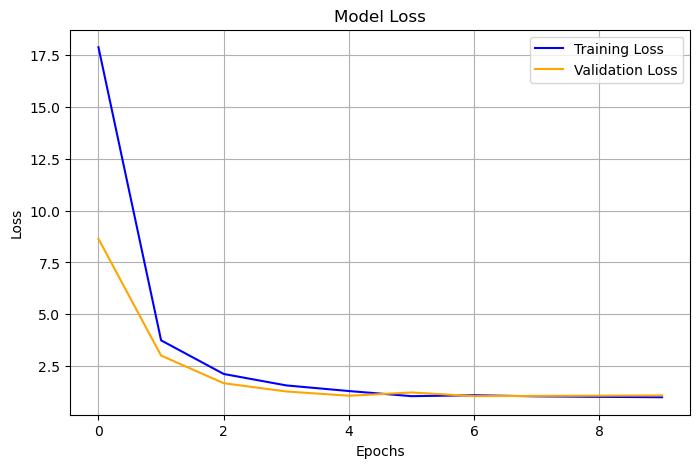

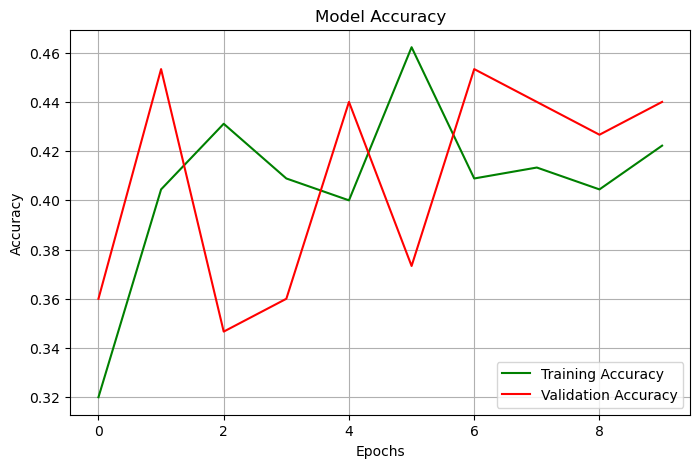

In [23]:
plot_loss_and_accuracy(history_0)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
              precision    recall  f1-score   support

           0       0.19      0.83      0.31        52
           1       0.41      0.14      0.21        85
           2       0.69      0.16      0.26       152

    accuracy                           0.27       289
   macro avg       0.43      0.38      0.26       289
weighted avg       0.52      0.27      0.25       289



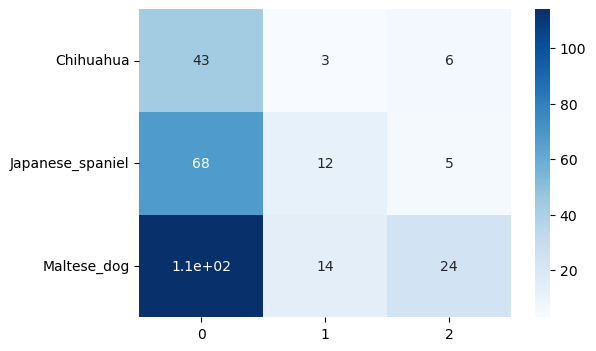

In [24]:
display_matrix_scores(model_0, "model_0")

### First modification : batch size

In [25]:
train_flow_batch16 = data_flow_fct(train_df_reduced, datagen_train, batch_size=16)
val_flow_batch16 = data_flow_fct(val_df_reduced, datagen_train, batch_size=16)

Found 225 validated image filenames belonging to 3 classes.
Found 75 validated image filenames belonging to 3 classes.


/home/omar-oc/anaconda3/envs/env_OC_P6/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │    25,233,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,234,563 (96.26 MB)

 Trainable params: 25,234,563 (96.26 MB)

 Non-trainable params: 0 (0.00 B)

None


/home/omar-oc/anaconda3/envs/env_OC_P6/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.4469 - loss: 26.6754
Epoch 1: val_loss improved from inf to 3.12001, saving model to models/model_1_batch16.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 378ms/step - accuracy: 0.4462 - loss: 26.0449 - val_accuracy: 0.3867 - val_loss: 3.1200
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.4286 - loss: 2.0735
Epoch 2: val_loss improved from 3.12001 to 1.34941, saving model to models/model_1_batch16.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - accuracy: 0.4285 - loss: 2.0568 - val_accuracy: 0.4133 - val_loss: 1.3494
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.5027 - loss: 1.2508
Epoch 3: val_loss improved from 1.34941 to 1.08454, saving model to models/model_1_batch16.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 370ms/step - accuracy: 0.5024 - loss: 1.2482 - val_accuracy: 0.4933 - val_loss: 1.0845
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.4893 - loss: 1.0030
Epoch 4: val_los

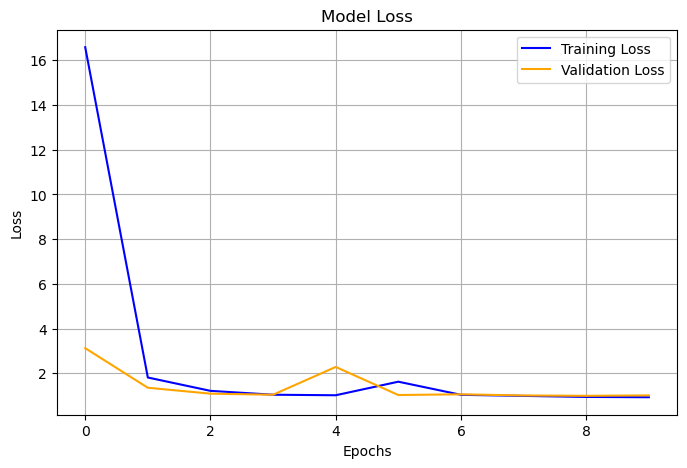

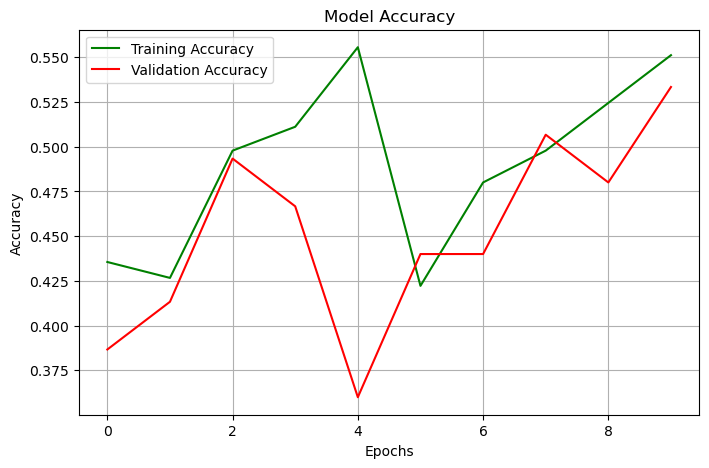

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
              precision    recall  f1-score   support

           0       0.11      0.15      0.13        52
           1       0.28      0.48      0.36        85
           2       0.45      0.22      0.29       152

    accuracy                           0.28       289
   macro avg       0.28      0.28      0.26       289
weighted avg       0.34      0.28      0.28       289



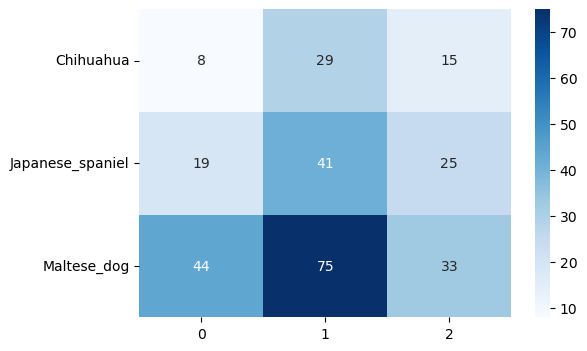

In [26]:
model_1 = create_model_custom_0()
callbacks_list_1 = create_model_callback("model_1_batch16")
history_1 = train_model(model_1, callbacks_list_1, train_flow_batch16, val_flow_batch16, batch_size=16) # batch size : 32 -> 16
plot_loss_and_accuracy(history_1)
display_matrix_scores(model_1, "model_1_batch16")

### Second modification : optimizer learning rate

/home/omar-oc/anaconda3/envs/env_OC_P6/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │    25,233,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,234,563 (96.26 MB)

 Trainable params: 25,234,563 (96.26 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.3837 - loss: 180.1127
Epoch 1: val_loss improved from inf to 1.09702, saving model to models/model_2_lr.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 749ms/step - accuracy: 0.3821 - loss: 174.3963 - val_accuracy: 0.3600 - val_loss: 1.0970
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.3138 - loss: 1.0986
Epoch 2: val_loss did not improve from 1.09702
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 490ms/step - accuracy: 0.3155 - loss: 1.0986 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.3309 - loss: 1.0996
Epoch 3: val_loss did not improve from 1.09702
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 461ms/step - accuracy: 0.3312 - loss: 1.0996 - val_accuracy: 0.3333 - val_loss: 1.0987
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.3356 - loss: 1.0972
Epoch 4: val_loss did not improve from 1.09702
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 475ms/step - accuracy: 0.3354 - loss: 1.0975 - val_ac

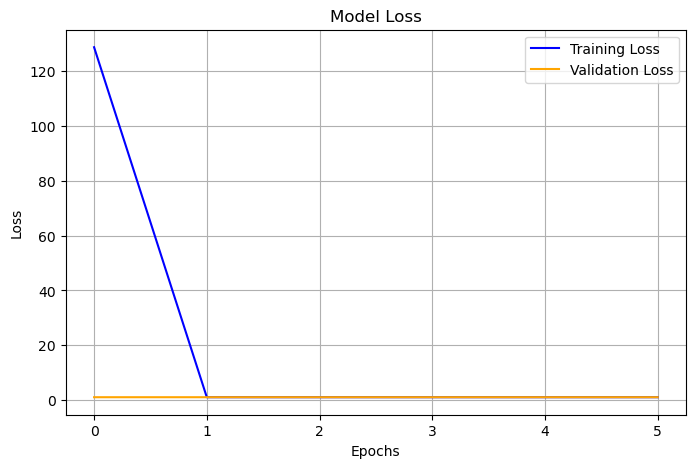

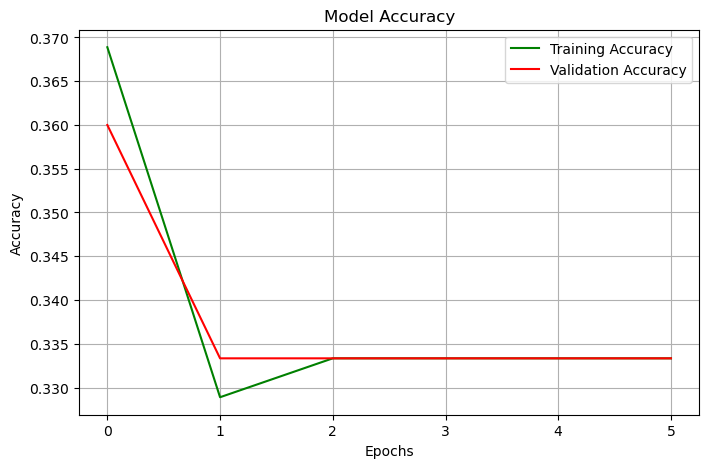

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
              precision    recall  f1-score   support

           0       0.19      0.60      0.28        52
           1       0.50      0.01      0.02        85
           2       0.54      0.43      0.48       152

    accuracy                           0.34       289
   macro avg       0.41      0.35      0.26       289
weighted avg       0.46      0.34      0.31       289



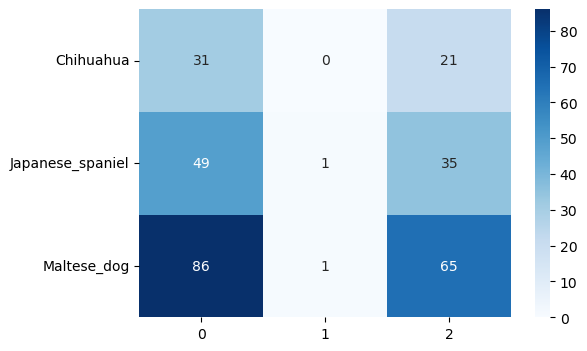

In [27]:
model_2 = create_model_custom_2() # learning rate : 1e-3 -> 1e-2
callbacks_list_2 = create_model_callback("model_2_lr")
history_2 = train_model(model_2, callbacks_list_2)
plot_loss_and_accuracy(history_2)
display_matrix_scores(model_2, "model_2_lr")

### Third modification : more epochs and patience

/home/omar-oc/anaconda3/envs/env_OC_P6/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │    25,233,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,234,563 (96.26 MB)

 Trainable params: 25,234,563 (96.26 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.2783 - loss: 36.7882
Epoch 1: val_loss improved from inf to 15.93805, saving model to models/model_3_patience10.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 751ms/step - accuracy: 0.2834 - loss: 36.1523 - val_accuracy: 0.3333 - val_loss: 15.9380
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.3757 - loss: 8.9117
Epoch 2: val_loss improved from 15.93805 to 2.69467, saving model to models/model_3_patience10.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 667ms/step - accuracy: 0.3749 - loss: 8.5991 - val_accuracy: 0.3333 - val_loss: 2.6947
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.3435 - loss: 1.7686
Epoch 3: val_loss improved from 2.69467 to 1.09863, saving model to models/model_3_patience10.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 640ms/step - accuracy: 0.3419 - loss: 1.7260 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.3547 - loss: 1.0984
Epoch 4: val_

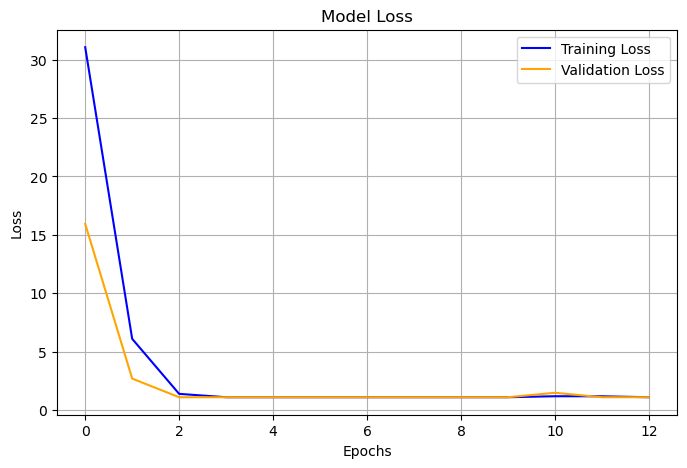

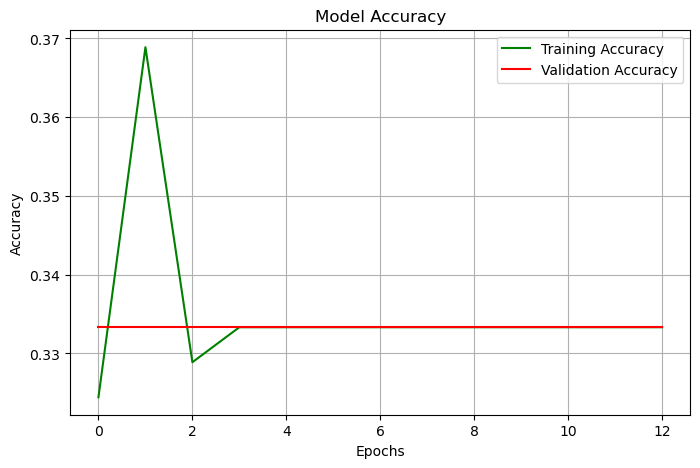

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
              precision    recall  f1-score   support

           0       0.18      1.00      0.30        52
           1       0.00      0.00      0.00        85
           2       0.00      0.00      0.00       152

    accuracy                           0.18       289
   macro avg       0.06      0.33      0.10       289
weighted avg       0.03      0.18      0.05       289



/home/omar-oc/anaconda3/envs/env_OC_P6/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/omar-oc/anaconda3/envs/env_OC_P6/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/omar-oc/anaconda3/envs/env_OC_P6/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

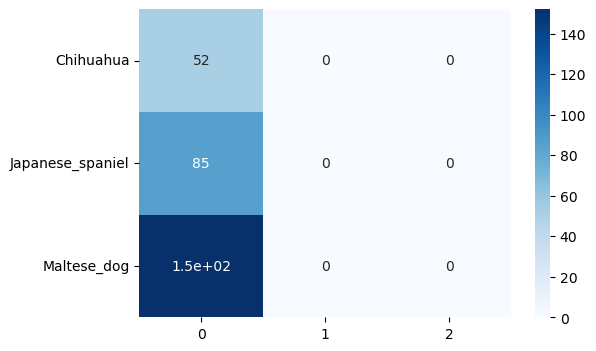

In [28]:
model_3 = create_model_custom_0(train_flow)
callbacks_list_3 = create_model_callback_patience10("model_3_patience10")
history_3 = train_model(model_3, callbacks_list_3, nb_epochs=30)
plot_loss_and_accuracy(history_3)
display_matrix_scores(model_3, "model_3_patience10")

### Fourth modification : adding layers

/home/omar-oc/anaconda3/envs/env_OC_P6/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,917,827 (91.24 MB)

 Trainable params: 23,917,827 (91.24 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.3166 - loss: 4.6125
Epoch 1: val_loss improved from inf to 1.19018, saving model to models/model_4_layers.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 739ms/step - accuracy: 0.3165 - loss: 4.5952 - val_accuracy: 0.3333 - val_loss: 1.1902
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 507ms/step - accuracy: 0.3158 - loss: 1.5978
Epoch 2: val_loss improved from 1.19018 to 1.09749, saving model to models/model_4_layers.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 731ms/step - accuracy: 0.3138 - loss: 1.5744 - val_accuracy: 0.3333 - val_loss: 1.0975
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.3392 - loss: 1.1002
Epoch 3: val_loss did not improve from 1.09749
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 630ms/step - accuracy: 0.3410 - loss: 1.1000 - val_accuracy: 0.3067 - val_loss: 1.0982
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.3260 - loss: 1.1258
Epoch 4: val_loss did not improve from 1.09749
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 611m

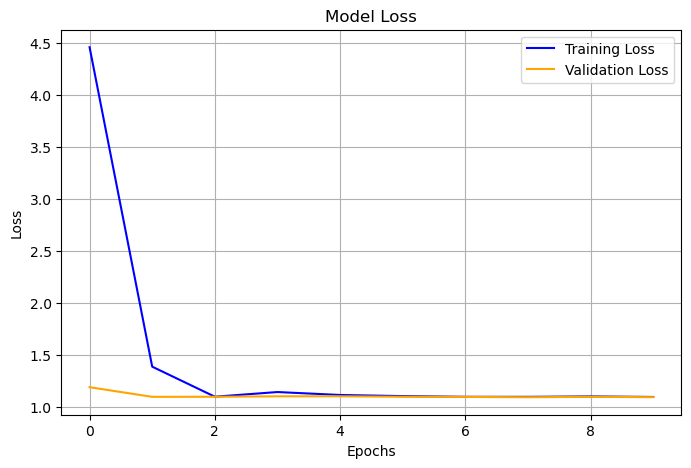

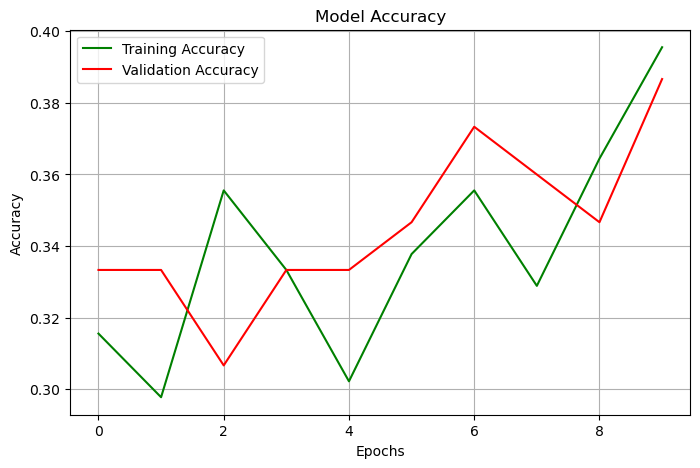

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
              precision    recall  f1-score   support

           0       0.08      0.06      0.07        52
           1       0.25      0.02      0.04        85
           2       0.52      0.84      0.64       152

    accuracy                           0.46       289
   macro avg       0.28      0.31      0.25       289
weighted avg       0.36      0.46      0.36       289



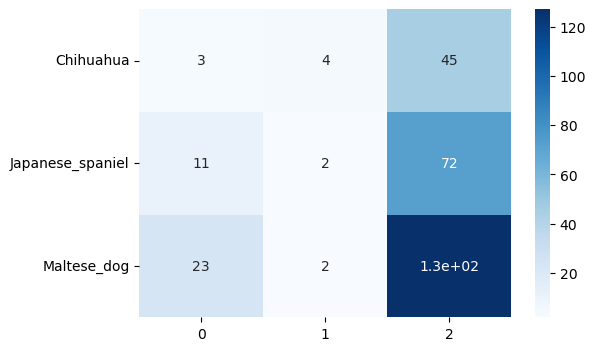

In [29]:
model_4 = create_model_custom_4(train_flow)
callbacks_list_4 = create_model_callback("model_4_layers")
history_4 = train_model(model_4, callbacks_list_4)
plot_loss_and_accuracy(history_4)
display_matrix_scores(model_4, "model_4_layers")

### Last modificatoin : without data augmentation

/home/omar-oc/anaconda3/envs/env_OC_P6/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │    25,233,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,234,563 (96.26 MB)

 Trainable params: 25,234,563 (96.26 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/home/omar-oc/anaconda3/envs/env_OC_P6/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.3350 - loss: 18.0807
Epoch 1: val_loss improved from inf to 1.60256, saving model to models/model_5_without_data_augm.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 507ms/step - accuracy: 0.3437 - loss: 17.4862 - val_accuracy: 0.4267 - val_loss: 1.6026
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.5439 - loss: 1.2904
Epoch 2: val_loss did not improve from 1.60256
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 377ms/step - accuracy: 0.5427 - loss: 1.2876 - val_accuracy: 0.3333 - val_loss: 2.7592
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.4392 - loss: 1.9216
Epoch 3: val_loss improved from 1.60256 to 1.31284, saving model to models/model_5_without_data_augm.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 485ms/step - accuracy: 0.4486 - loss: 1.8936 - val_accuracy: 0.5867 - val_loss: 1.3128
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.5878 - loss: 1.0357
Epoch 4: val_loss did not improve from 1.31284
8/8 ━━━━━━━━━━━━━━━━━━━━

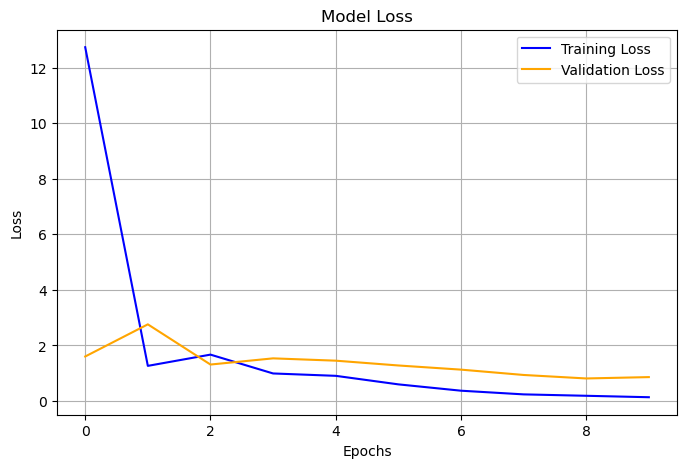

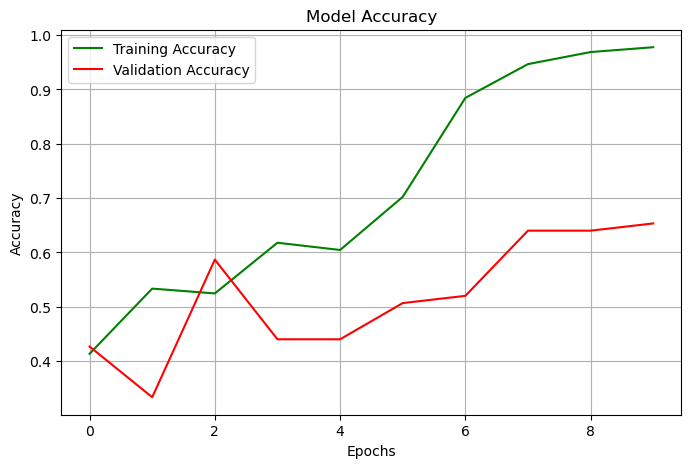

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step 
              precision    recall  f1-score   support

           0       0.16      0.17      0.17        52
           1       0.34      0.40      0.37        85
           2       0.57      0.51      0.54       152

    accuracy                           0.42       289
   macro avg       0.36      0.36      0.36       289
weighted avg       0.43      0.42      0.42       289



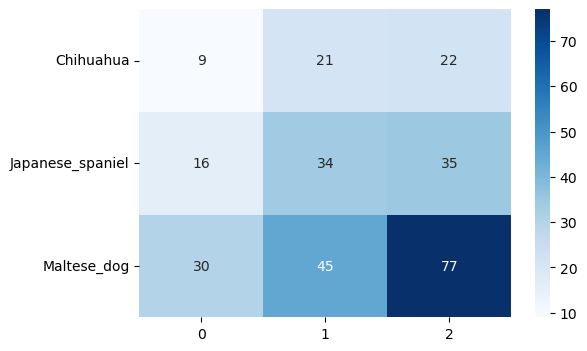

In [30]:
model_5 = create_model_custom_0()
callbacks_list_5 = create_model_callback("model_5_without_data_augm")
history_5 = train_model(model_5, callbacks_list_5, train_flow_not_augmented, val_flow_not_augmented)
plot_loss_and_accuracy(history_5)
display_matrix_scores(model_5, "model_5_without_data_augm")

# Choice : base model

In [31]:
results_df

,model_name,accuracy on test set
0,model_0,0.259227
1,model_1_batch16,0.259979
2,model_2_lr,0.261194
3,model_3_patience10,0.101662
4,model_4_layers,0.250614
5,model_5_without_data_augm,0.358084


No data augmentation, 10 epochs

# Building a complete training pipeline

In [19]:
def complete_ml_pipeline(
        model_name,
        create_model_fct=create_model_custom_0,
        nb_epochs=10,
        batch_size=32,
        create_model_callback_fct=create_model_callback,
        labels=['Chihuahua', 'Japanese_spaniel', 'Maltese_dog'],
        datagen_train=datagen_train_not_augmented,
        datagen_test=datagen_test,
        results_df=results_df      
):
    
    train_val_df_reduced = train_df.loc[train_df.label_name.apply(lambda x: x in labels), :]
    test_df_reduced = test_df.loc[test_df.label_name.apply(lambda x: x in labels), :]

    train_df_reduced, val_df_reduced = train_test_split(
        train_val_df_reduced, 
        test_size=0.25, 
        stratify=train_val_df_reduced['label_name'],
        random_state=42
    )
    
    train_flow = data_flow_fct(train_df_reduced, datagen_train, batch_size=batch_size)
    val_flow = data_flow_fct(val_df_reduced, datagen_train, batch_size=batch_size)

    test_flow = data_flow_fct(test_df_reduced, datagen_test, batch_size=batch_size)

    callbacks_list = create_model_callback_fct(model_name)
    model = create_model_fct(train_flow)
    history = train_model(model, callbacks_list, train_flow=train_flow, val_flow=val_flow, nb_epochs=nb_epochs, batch_size=batch_size)
    plot_loss_and_accuracy(history)
    display_matrix_scores(model, model_name, test_flow)

    return model

Found 225 validated image filenames belonging to 3 classes.
Found 75 validated image filenames belonging to 3 classes.
Found 289 validated image filenames belonging to 3 classes.


/home/omar-oc/anaconda3/envs/env_OC_P6/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 394272)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    25,233,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,234,563 (96.26 MB)

 Trainable params: 25,234,563 (96.26 MB)

 Non-trainable params: 0 (0.00 B)

None


/home/omar-oc/anaconda3/envs/env_OC_P6/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.3773 - loss: 21.1704
Epoch 1: val_loss improved from inf to 8.96001, saving model to models/final_custom_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 495ms/step - accuracy: 0.3739 - loss: 21.1169 - val_accuracy: 0.3333 - val_loss: 8.9600
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.4705 - loss: 4.5528
Epoch 2: val_loss improved from 8.96001 to 2.94912, saving model to models/final_custom_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 460ms/step - accuracy: 0.4705 - loss: 4.4810 - val_accuracy: 0.3333 - val_loss: 2.9491
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.4377 - loss: 1.8573
Epoch 3: val_loss improved from 2.94912 to 1.54555, saving model to models/final_custom_model.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step - accuracy: 0.4384 - loss: 1.8280 - val_accuracy: 0.3867 - val_loss: 1.5455
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.5065 - loss: 1.4640
Epoch 4: val_loss imp

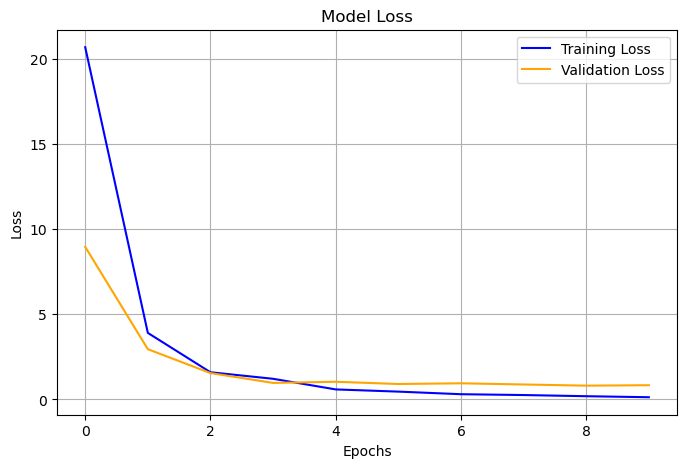

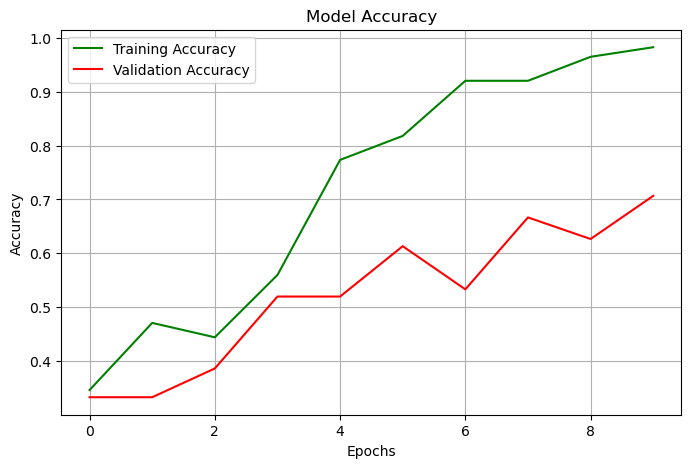

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
              precision    recall  f1-score   support

           0       0.19      0.25      0.21        52
           1       0.34      0.24      0.28        85
           2       0.53      0.56      0.54       152

    accuracy                           0.41       289
   macro avg       0.35      0.35      0.35       289
weighted avg       0.41      0.41      0.41       289



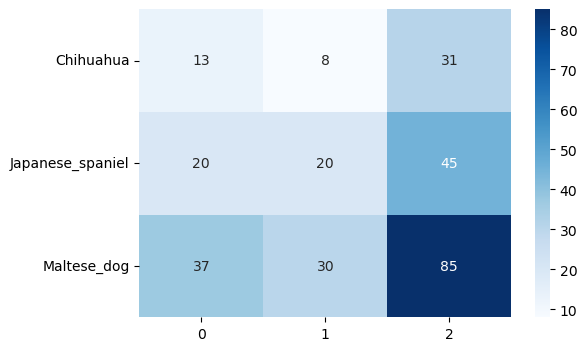

In [20]:
model = complete_ml_pipeline("final_custom_model")

In [21]:
results_df

,model_name,accuracy on test set
0,final_custom_model,0.345322


In [22]:
model.save("models/final_custom_model.hdf5")